In [ ]:
!nvidia-smi

Mon Sep  7 01:27:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

import string

path = '/content/gdrive/My Drive/Dacon/ComputerVision/'

path_train = path + 'train.csv'
path_test = path + 'test.csv'
path_submission = path + 'submission.csv'

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


GAN - 1
-----------

In [ ]:
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)

ImageGen_coeff = 10
epochs_num = 50
batch_size = 32
verbose = 2
N_dim = 224
ModelName = 'GAN_224'
latent_dim = 2

In [ ]:
def normalization(df):\
    for row in range(len(df)):
        maxi = df.iloc[row].max()
        mini = df.iloc[row].min()
        if maxi == mini:
            df.iloc[row] = df.iloc[row].apply(lambda x : 0)
        else:
            df.iloc[row] = df.iloc[row].apply(lambda x : (x - mini)/(maxi - mini))
    x = df.values
    if not np.any(x > 1.0) and not np.any(x < 0) and not np.any(np.isnan(x)):
        print('Boundary Clear')      
    return df

def ComputerVision_Dataset():
    train_data = pd.read_csv('/content/gdrive/My Drive/Dacon/ComputerVision/train.csv')
    train_data_pixel = pd.read_csv('/content/gdrive/My Drive/Dacon/ComputerVision/train_bicubic'+str(N_dim)+'.csv')

    letter_hash = dict(zip(string.ascii_uppercase, [[1 if i == j else 0 for j in range(26)] for i in range(26)]))

    pix = train_data_pixel.iloc[:, 1:]
    pix = normalization(pix).values.reshape(-1, N_dim, N_dim, 1)

    fix = train_data.iloc[:, 1:3].values
    with tf.device('/device:GPU:0'):
        datagenerator = ImageDataGenerator(rotation_range=10, zoom_range=0.10, width_shift_range=0.1,
                                          height_shift_range=0.1)
        gen = datagenerator.flow(pix, fix, shuffle=False, batch_size=32)
        pixel, fixed, batch_index, limit = [], [], 0, 64 * ImageGen_coeff
        while batch_index <= limit:
            try:
                data = gen.next()
                pixel += list(data[0])
                fixed += list(data[1])
                batch_index += 1
            except:
                print("ImageGeneratorError")
                break
    fixed_train = np.asarray(fixed)
    X_train_pixel = np.asarray(pixel)
    Y_train = to_categorical(fixed_train[:, 0], 10)
    X_train_label = np.asarray([letter_hash[letter] for letter in fixed_train[:, 1]])


    return X_train_label, X_train_pixel, Y_train

_, train_dataset, _ = ComputerVision_Dataset()

Boundary Clear


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset).shuffle(train_dataset.shape[0]).batch(batch_size)

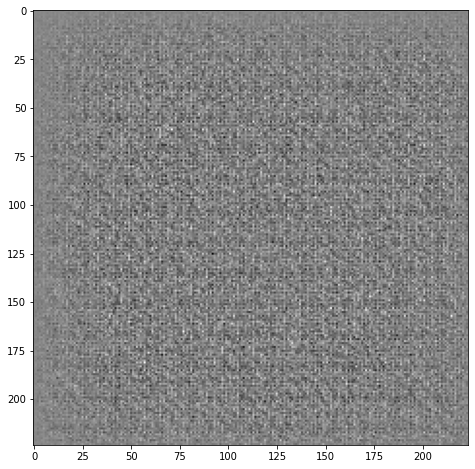

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(14*14*128, use_bias=False, input_shape=(200,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((14, 14, 128)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) # (14,14,128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)) # (28,28,128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)) # (56,56,64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)) # (112,112,64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')) # (224,224,1)

    return model

generator = make_generator_model()

noise = tf.random.normal([1, 200])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[224, 224, 1])) # (112,112,32)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same')) # (56,56,32)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')) # (28,28,64)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')) # (14,14,64)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) # (7,7,128)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model
    
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00014428]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, 200])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
seed = tf.random.normal([4, 200])
def generate_images(model,test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(10,40))

  for i in range(predictions.shape[0]):
      plt.subplot(1, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')
  plt.show()

import time
def train(dataset, epochs):
    with tf.device('/device:GPU:0'):
        for epoch in range(epochs_num):
            start = time.time()

            for image_batch in dataset:
                train_step(image_batch)

            generate_images(generator,seed)

            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

train(train_dataset, epochs_num)

Output hidden; open in https://colab.research.google.com to view.

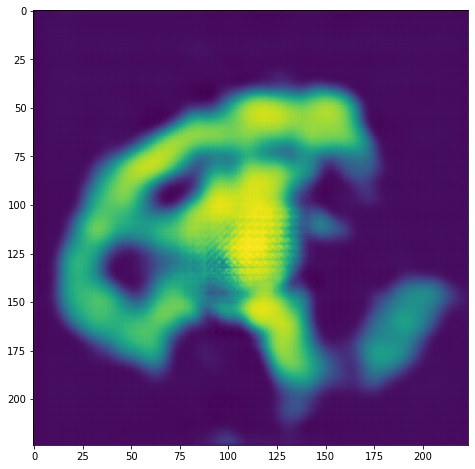

In [ ]:
noise = tf.random.normal([1, 200])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
generator.save(path + ModelName + '.h5')

normalization?

In [ ]:
train_file = pd.read_csv(path_train)
pixel = train_file.iloc[:,3:].values.astype('int32').reshape(-1,28,28,1)
with tf.device('/device:GPU:0'):
    pixel_re = tf.image.resize(np.asarray(pixel), [N_dim,N_dim], method = tf.image.ResizeMethod.BICUBIC)
    pixel_normal = tf.image.per_image_standardization(pixel_re).numpy()

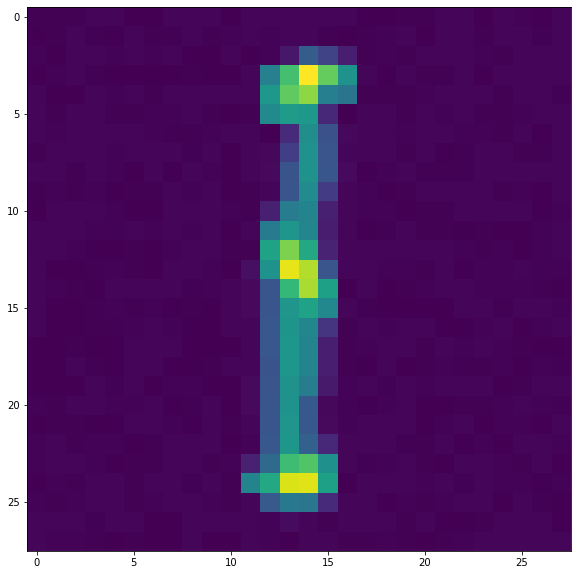

In [ ]:
def image_view0(nump):
    pixels = nump.reshape((28,28))
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.imshow(pixels)
    plt.show()
def image_view(nump):
    pixels = nump.reshape((224,224))
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.imshow(pixels)
    plt.show()

n = 0
image_view0(pixel[n])
image_view(pixel_re.numpy()[n])
image_view(pixel_normal[n])

GAN - 2
-----------

In [ ]:
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)

ImageGen_coeff = 10
epochs_num = 50
batch_size = 32
verbose = 2
N_dim = 224
ModelName = 'GAN_224_2'
latent_dim = 2

In [ ]:
def prepare_datasets():
    train_raw = pd.read_csv(path_train)

    letter_hash = dict(zip(string.ascii_uppercase, [[1 if i == j else 0 for j in range(26)] for i in range(26)]))
    letter_hash_func = lambda letter : letter_hash[letter]

    pix = train_raw.iloc[:,3:].values.astype('int32').reshape(-1,28,28,1)
    fix = train_raw.iloc[:,1:3].values
    datagenerator = ImageDataGenerator(rotation_range=10, zoom_range=0.10, width_shift_range=0.1,height_shift_range=0.1)
    gen = datagenerator.flow(pix, fix, shuffle=False, batch_size=32)
    pixel, fixed, batch_index, limit = [], [], 0, 64 * ImageGen_coeff
    while batch_index <= limit:
        try:
            data = gen.next()
            pixel += list(data[0])
            fixed += list(data[1])
            batch_index += 1
        except:
            print("ImageGeneratorError")
            break
    # print(np.asarray(pixel).shape)
    with tf.device('/device:GPU:0'):
        train_pixel = tf.image.resize(np.asarray(pixel), [N_dim,N_dim], method = tf.image.ResizeMethod.BICUBIC)
        train_pixel = tf.image.per_image_standardization(train_pixel).numpy()
        train_label = np.asarray(list(map(letter_hash_func, np.asarray(fixed)[:,1])))
        train_answer = to_categorical(np.asarray(fixed)[:,0], 10)

    train_label = np.concatenate((train_label,train_answer),axis = 1).astype('float32')

    return train_pixel, train_label

train_pixel, train_label = prepare_datasets()
print(train_pixel.shape, train_label.shape)

(20512, 224, 224, 1) (20512, 36)


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_pixel,train_label)).shuffle(train_label.shape[0]).batch(batch_size)

In [ ]:
def generate_seed(letter, digit):
    # inputs must be lists of the same length
    letter_hash = dict(zip(string.ascii_uppercase, [[1 if i == j else 0 for j in range(26)] for i in range(26)]))
    label = np.concatenate((np.asarray([letter_hash[l] for l in letter]),to_categorical(digit, 10)),axis = 1)
    seed = tf.concat([tf.random.normal([len(digit), 200]),label],1)
    return seed

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(14*14*128, use_bias=False, input_shape=(236,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((14, 14, 128)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) # (14,14,128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)) # (28,28,128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)) # (56,56,64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)) # (112,112,64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')) # (224,224,1)

    return model

generator = make_generator_model()

noise = generate_seed(['A'], [1])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[224, 224, 1])) # (112,112,32)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same')) # (56,56,32)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')) # (28,28,64)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')) # (14,14,64)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) # (7,7,128)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model
    
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-1.2400826e-05]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(x_true, x_recons_logits,fake_output):
    raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=x_true, logits=x_recons_logits)
    neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1, 2, 3])
    return tf.math.reduce_mean(neg_log_likelihood) * 10 ** (-5) + cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
@tf.function
def train_step(batch):
    images, labels = batch
    noise = tf.concat([tf.random.normal([batch_size, 200]),labels],1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(images,generated_images,fake_output)
      # tf.print(gen_loss)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Time for epoch 1 is 35.78005814552307 sec


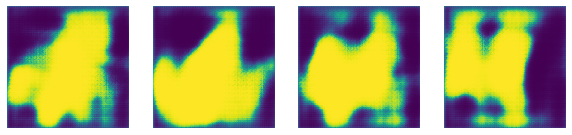

Time for epoch 2 is 34.572815895080566 sec


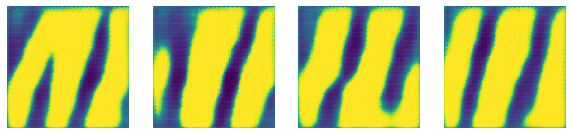

Time for epoch 3 is 32.685643911361694 sec


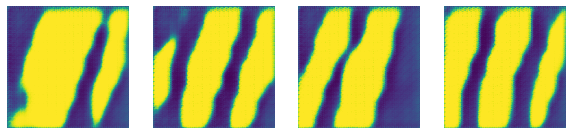

Time for epoch 4 is 32.87339806556702 sec


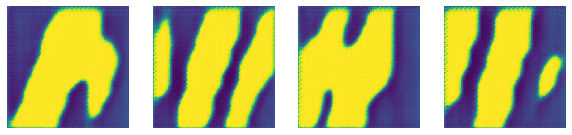

Time for epoch 5 is 32.5471625328064 sec


Time for epoch 6 is 32.5428364276886 sec


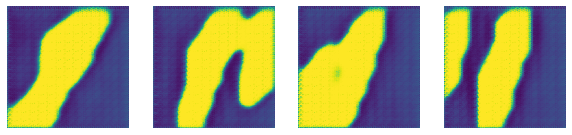

Time for epoch 7 is 32.40764784812927 sec


Time for epoch 8 is 32.476635456085205 sec


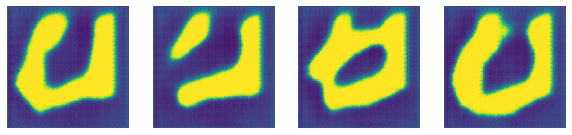

Time for epoch 9 is 32.4523401260376 sec


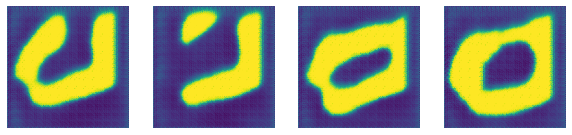

Time for epoch 10 is 32.654120445251465 sec


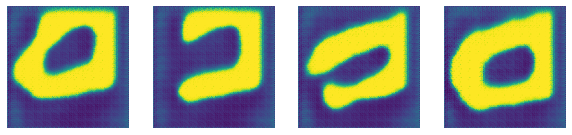

Time for epoch 11 is 32.477370500564575 sec


Time for epoch 12 is 32.44007921218872 sec


Time for epoch 13 is 32.391743183135986 sec


Time for epoch 14 is 32.525423526763916 sec


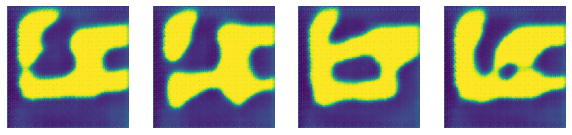

Time for epoch 15 is 32.43260931968689 sec


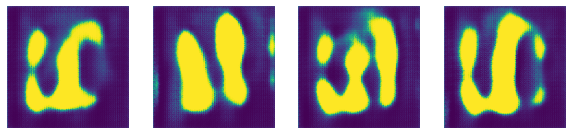

Time for epoch 16 is 32.36898589134216 sec


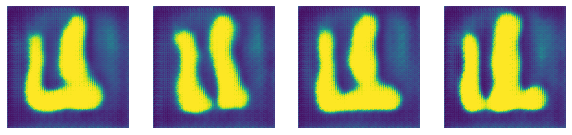

Time for epoch 17 is 32.45368432998657 sec


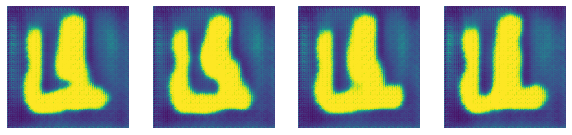

Time for epoch 18 is 32.40160036087036 sec


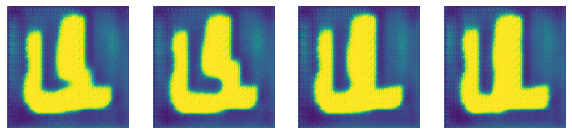

Time for epoch 19 is 32.397948265075684 sec


Time for epoch 20 is 32.35189414024353 sec


Time for epoch 21 is 32.34916067123413 sec


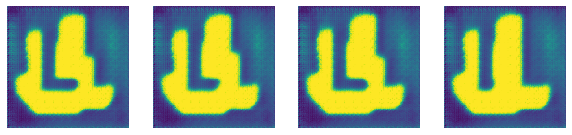

Time for epoch 22 is 32.35239315032959 sec


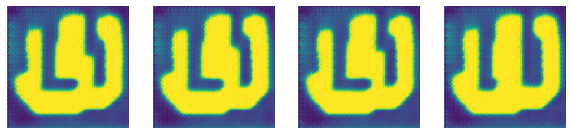

Time for epoch 23 is 32.34899687767029 sec


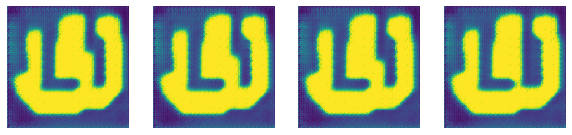

Time for epoch 24 is 32.5337872505188 sec


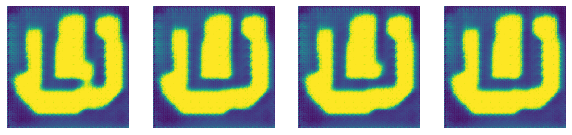

Time for epoch 25 is 32.37365508079529 sec


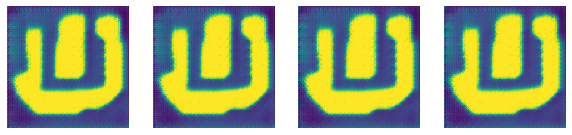

Time for epoch 26 is 32.55580997467041 sec


Time for epoch 27 is 32.32301688194275 sec


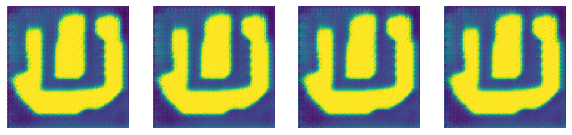

Time for epoch 28 is 32.35338377952576 sec


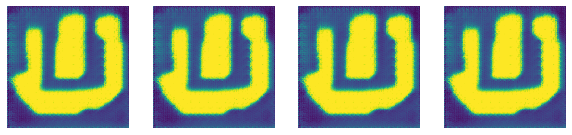

Time for epoch 29 is 32.268320083618164 sec


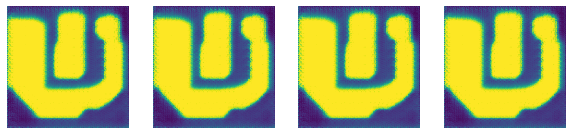

Time for epoch 30 is 32.384886026382446 sec


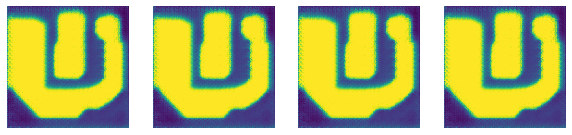

Time for epoch 31 is 32.27464461326599 sec


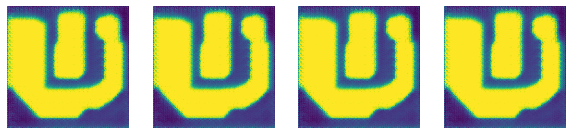

Time for epoch 32 is 32.33267116546631 sec


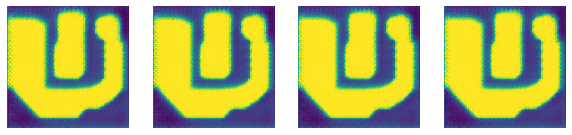

Time for epoch 33 is 32.260215282440186 sec


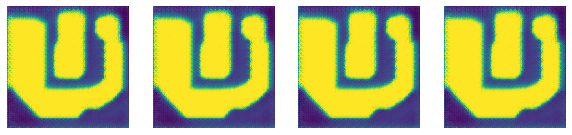

Time for epoch 34 is 32.49592423439026 sec


Time for epoch 35 is 32.30737233161926 sec


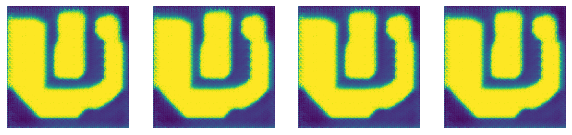

Time for epoch 36 is 32.42132115364075 sec


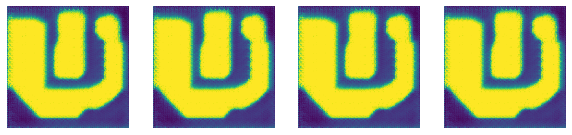

Time for epoch 37 is 32.340505838394165 sec


Time for epoch 38 is 32.301491022109985 sec


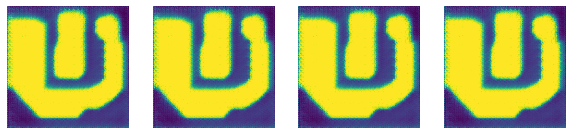

Time for epoch 39 is 32.31267499923706 sec


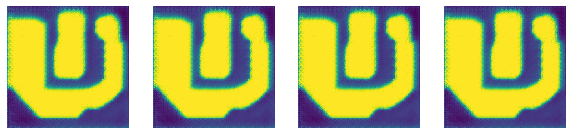

Time for epoch 40 is 32.33060002326965 sec


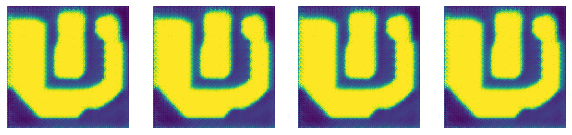

Time for epoch 41 is 32.34931468963623 sec


Time for epoch 42 is 32.31270170211792 sec


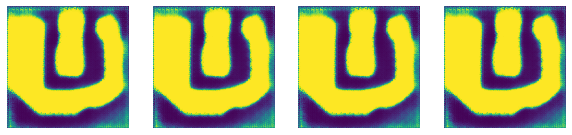

Time for epoch 43 is 32.355502128601074 sec


Time for epoch 44 is 32.488704204559326 sec


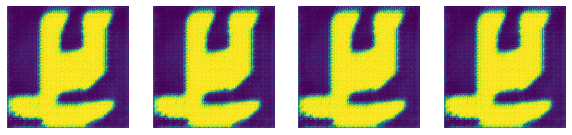

Time for epoch 45 is 32.39855360984802 sec


In [ ]:
seed = generate_seed(['A','B','C','D'],[4,5,6,7])

def generate_images(model,test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(10,40))

  for i in range(predictions.shape[0]):
      plt.subplot(1, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')
  plt.show()

import time
def train(dataset, epochs):
    with tf.device('/device:GPU:0'):
        for epoch in range(epochs_num):
            start = time.time()

            for image_batch in dataset:
                train_step(image_batch)

            generate_images(generator,seed)

            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

train(train_dataset, epochs_num)

In [ ]:
generator.save(path + ModelName + '.h5')